# Description
The code below does the following:

* Download historical position data for the INTEGRAL spacecraft
* Reads the CDF files describing WIND's trajectory
* Plots the trajectory of both spacecrafts

Parameters:

In [12]:
from datetime import datetime, timezone, timedelta
startDate = datetime(2012, 10, 1, tzinfo=timezone.utc)
endDate = datetime(2012, 12, 1, tzinfo=timezone.utc)

Configuring Plotly for offline use in notebook

In [13]:
import plotly.offline as py
py.init_notebook_mode(connected=True)

# INTEGRAL

Downloading INTEGRAL position data

In [14]:
integralSpiceId = '-198'
observer = '500' # Earth
from astroquery.jplhorizons import Horizons
epochs = {'start': '{:4d}-{:02d}-{:02d}'.format(startDate.year, startDate.month, startDate.day),
                         'stop': '{:4d}-{:02d}-{:02d}'.format(endDate.year, endDate.month, endDate.day),
                         'step': '10m'}
obj = Horizons(id=integralSpiceId,
               location=observer,
               epochs=epochs,
               id_type='id')
vec = obj.vectors()
eph = obj.ephemerides()

Converting the position and date format

In [15]:
# By default, coordinates should be in J2000 ecliptic coordinates, but not sure...
import numpy as np
integralDate_jd = np.array([row[1] for row in vec]) # Date is defined in Julian date format
integralPosition_au = np.array([[row[3], row[4], row[5]] for row in vec])
integralDateTime = np.array([datetime.strptime(row[2], 'A.D. %Y-%b-%d %H:%M:%S.%f')
                            for row in vec])
au2km = 149597870.7
integralPosition_km = au2km * integralPosition_au

Plotting INTEGRAL's trajectory using Plotly:

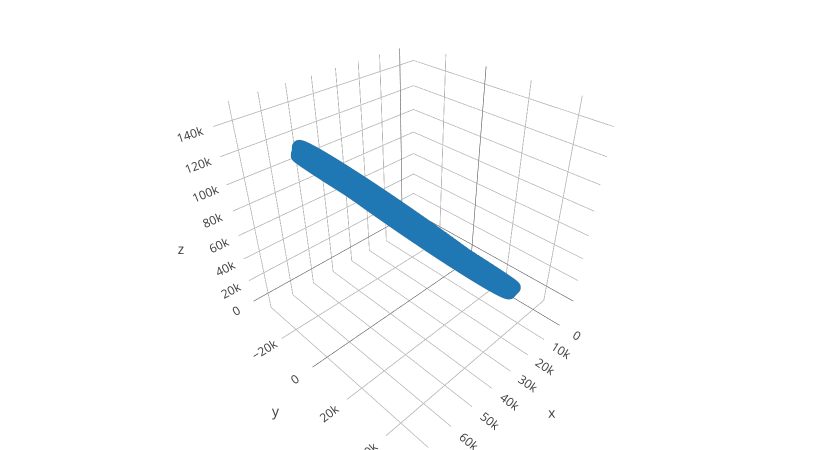

In [19]:
import plotly.graph_objs as go
import pandas as pd

trace = go.Scatter3d(
    x=integralPosition_km[:,0], y=integralPosition_km[:,1], z=integralPosition_km[:,2],
    line=dict(
        color='#1f77b4',
        width=1
    )
)

data = [trace]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = dict(data=data, layout=layout)
fig['layout']['scene'].update(go.layout.Scene(aspectmode='cube'))

py.iplot(fig)

# WIND
Reading WIND trajectory from CDF files

In [20]:
import cdflib
from pathlib import Path
windPosition_km = None
windDateTime = None
p = Path('.')
for windFileName in sorted(p.glob('wind_trajectory/*/*.cdf')):
    fileNameWithoutPath = windFileName.name
    fileYear = int(fileNameWithoutPath[10:14])
    fileMonth = int(fileNameWithoutPath[14:16])
    fileDay = int(fileNameWithoutPath[16:18])
    fileDate = datetime(fileYear, fileMonth, fileDay, tzinfo=timezone.utc)
    if (fileDate >= startDate) and (fileDate <= endDate):
        cdfFile = cdflib.CDF(windFileName)
        gciPos = cdfFile.varget(variable='GCI_POS')
        # Getting position in Geocentric equatorial inertial (GCI)
        # Other frames are available in the CDF file:
        #   - Geocentric solar ecliptic (GSE) frame
        #   - Geocentric solar magnetic (GSM)
        timePb5 = cdfFile.varget(variable='Time_PB5')
        currentDateTime = [datetime(pb5cur[0], 1, 1) + timedelta(days=pb5cur[1].item()-1) + timedelta(milliseconds=pb5cur[2].item()) for pb5cur in timePb5]
            
        if windPosition_km is None:
            windPosition_km = gciPos
            windDateTime = currentDateTime
        else:
            windPosition_km = np.concatenate((windPosition_km, gciPos))
            windDateTime = np.concatenate((windDateTime, currentDateTime))
            

# Plotting both spacecrafts

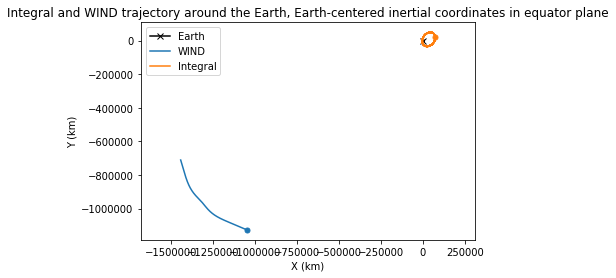

In [21]:
%matplotlib inline

R_earth_km = 6371.0
x_earth_km = np.array([R_earth_km * np.cos(t) for t in np.linspace(0, 2*np.pi, 100)])
y_earth_km = np.array([R_earth_km * np.sin(t) for t in np.linspace(0, 2*np.pi, 100)])

## Plotting
import matplotlib.pyplot as plt
plt.plot(x_earth_km, y_earth_km, 'k')
plt.plot(0.0, 0.0, 'k', marker='x', label='Earth')
plt.plot(windPosition_km[:, 0], windPosition_km[:, 1], 'C0', label='WIND',)
plt.plot(windPosition_km[-1, 0], windPosition_km[-1, 1], 'C0', marker='.', markersize=10)
plt.plot(integralPosition_km[:, 0], integralPosition_km[:, 1], 'C1', label='Integral')
plt.plot(integralPosition_km[-1, 0], integralPosition_km[-1, 1], 'C1', marker='.', markersize=10)
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Integral and WIND trajectory around the Earth, Earth-centered inertial coordinates in equator plane')
plt.axis('equal')
plt.legend()
plt.show()